# RNN - Many-to-one stacking
> In this post, We will extend the many-to-one RNN model with stacked version. And it will show the simple implementation in tensorflow

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Tensorflow-Keras]
- image: 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.3.1


## What is "stacking"

Previously, we covered the many-to-one type RNN model, which can classify the word tokens.

![many-to-one example](image/many-to-one.png) {% fn 1 %}

But what about more complex element, like setence? Of course, same process will be happened. But as you noticed, sometimes the meaning of word in specific sentence is different from meaning of word itself. For example, `not` contains negative meaning, but `not bad` intends positive meaning. Like this, we need to take a different approach in sentence classification.

In order to do this, the complex RNN model is required. More deeper, and more complex. Of course, it is not theoretically clear that has more advanced performance in deep model, but we can easily see the performance improvement in deep model on CNN archiecture. (See the example of AlexNet and VGG19)

![many-to-one stacked](image/rnn_many-to-one-stacked.png) {% fn 2 %}

And here is deeper version of many-to-one that consists of multi-layered RNNs. It is also called **"stacking"** since multi-layered RNN is some kind of stacked RNN layer.

![rnn_many-to-one-stacked_detailed](image/rnn_many-to-one-stacked_detailed.png) {% fn 3 %}

Usually, the hidden layer which close to output layer tends to encode more semantic information. And the hidden layer that close to input layer tends to encode more syntactic information. It means that the hidden layer in input side is concerned with the **amount** of data, and the hidden layer in output side concerned the **meaning** of the data.

## Example - sentence classification

In this example, we will implement stacked RNN model for sentence classification. At first, we prepare the sentence data, and its purpose is to clasify the speaker of sentence. If the sentence is spoken by `richard feynman`, the label will be 1, and if `albert einstein` told the target sentence, the label will be 0.

In [2]:
sentences = ['What I cannot create, I do not understand',
             'Intellectuals solve problems, geniuses prevent them',
             'A person who never made a mistake never tied anything new.',
             'The same equations have the same solutions']
y = [1, 0, 0, 1]

Same as previous example, we can build token dictionary.

In [3]:
char_set = ['<pad>'] + sorted(list(set(''.join(sentences))))
idx2char = {idx: char for idx, char in enumerate(char_set)}
char2idx = {char: idx for idx, char in enumerate(char_set)}

Of course, character set will be larger than before.

In [4]:
char_set

['<pad>',
 ' ',
 ',',
 '.',
 'A',
 'I',
 'T',
 'W',
 'a',
 'b',
 'c',
 'd',
 'e',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'y']

In [5]:
idx2char

{0: '<pad>',
 1: ' ',
 2: ',',
 3: '.',
 4: 'A',
 5: 'I',
 6: 'T',
 7: 'W',
 8: 'a',
 9: 'b',
 10: 'c',
 11: 'd',
 12: 'e',
 13: 'g',
 14: 'h',
 15: 'i',
 16: 'k',
 17: 'l',
 18: 'm',
 19: 'n',
 20: 'o',
 21: 'p',
 22: 'q',
 23: 'r',
 24: 's',
 25: 't',
 26: 'u',
 27: 'v',
 28: 'w',
 29: 'y'}

In [6]:
char2idx

{'<pad>': 0,
 ' ': 1,
 ',': 2,
 '.': 3,
 'A': 4,
 'I': 5,
 'T': 6,
 'W': 7,
 'a': 8,
 'b': 9,
 'c': 10,
 'd': 11,
 'e': 12,
 'g': 13,
 'h': 14,
 'i': 15,
 'k': 16,
 'l': 17,
 'm': 18,
 'n': 19,
 'o': 20,
 'p': 21,
 'q': 22,
 'r': 23,
 's': 24,
 't': 25,
 'u': 26,
 'v': 27,
 'w': 28,
 'y': 29}

Based on this mapping, we can build training dataset, same as before.

In [9]:
X = list(map(lambda sentence: [char2idx.get(char) for char in sentence], sentences))

print(X)

[[7, 14, 8, 25, 1, 5, 1, 10, 8, 19, 19, 20, 25, 1, 10, 23, 12, 8, 25, 12, 2, 1, 5, 1, 11, 20, 1, 19, 20, 25, 1, 26, 19, 11, 12, 23, 24, 25, 8, 19, 11], [5, 19, 25, 12, 17, 17, 12, 10, 25, 26, 8, 17, 24, 1, 24, 20, 17, 27, 12, 1, 21, 23, 20, 9, 17, 12, 18, 24, 2, 1, 13, 12, 19, 15, 26, 24, 12, 24, 1, 21, 23, 12, 27, 12, 19, 25, 1, 25, 14, 12, 18], [4, 1, 21, 12, 23, 24, 20, 19, 1, 28, 14, 20, 1, 19, 12, 27, 12, 23, 1, 18, 8, 11, 12, 1, 8, 1, 18, 15, 24, 25, 8, 16, 12, 1, 19, 12, 27, 12, 23, 1, 25, 15, 12, 11, 1, 8, 19, 29, 25, 14, 15, 19, 13, 1, 19, 12, 28, 3], [6, 14, 12, 1, 24, 8, 18, 12, 1, 12, 22, 26, 8, 25, 15, 20, 19, 24, 1, 14, 8, 27, 12, 1, 25, 14, 12, 1, 24, 8, 18, 12, 1, 24, 20, 17, 26, 25, 15, 20, 19, 24]]


Maybe the length of sentence is different from each other. And it requires padding that fix the format.

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence = 55
X = pad_sequences(sequences=X, maxlen=max_sequence, padding='post', truncating='post')

print(X)
print(y)

[[ 7 14  8 25  1  5  1 10  8 19 19 20 25  1 10 23 12  8 25 12  2  1  5  1
  11 20  1 19 20 25  1 26 19 11 12 23 24 25  8 19 11  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 5 19 25 12 17 17 12 10 25 26  8 17 24  1 24 20 17 27 12  1 21 23 20  9
  17 12 18 24  2  1 13 12 19 15 26 24 12 24  1 21 23 12 27 12 19 25  1 25
  14 12 18  0  0  0  0]
 [ 4  1 21 12 23 24 20 19  1 28 14 20  1 19 12 27 12 23  1 18  8 11 12  1
   8  1 18 15 24 25  8 16 12  1 19 12 27 12 23  1 25 15 12 11  1  8 19 29
  25 14 15 19 13  1 19]
 [ 6 14 12  1 24  8 18 12  1 12 22 26  8 25 15 20 19 24  1 14  8 27 12  1
  25 14 12  1 24  8 18 12  1 24 20 17 26 25 15 20 19 24  0  0  0  0  0  0
   0  0  0  0  0  0  0]]
[1, 0, 0, 1]


In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

<BatchDataset shapes: ((None, 55), (None,)), types: (tf.int32, tf.int32)>


In order to implement stacked many-to-one model, it is very simple. Just add the hidden layer from 1 to more. And here is new kind of layers, [TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed). Stacked RNN requires to handle sequence data. So first hidden layer sets the `return_sequences` to `True`. That is, outputs are generated sequentially. And to update the weight related on sequential data, this layer allows to apply a layer to every temporal slice of an input. And `Dropout` is used to avoid overfitting.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, TimeDistributed, Dropout, Dense

input_dim = len(char2idx)
output_dim = len(char2idx)

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              trainable=False, mask_zero=True, input_length=max_sequence,
              embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10, return_sequences=True),
    TimeDistributed(Dropout(rate=0.2)),
    SimpleRNN(units=10),
    Dense(units=2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 55, 30)            900       
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 55, 10)            410       
_________________________________________________________________
time_distributed (TimeDistri (None, 55, 10)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 1,542
Trainable params: 642
Non-trainable params: 900
_________________________________________________________________


In [13]:
# Creating loss function
def loss_fn(model, x, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True
    ))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [14]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb)
        grads = tape.gradient(target=tr_loss, sources=model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
        avg_tr_loss += tr_loss
        tr_step += 1
        
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:.3f}'.format(e + 1, avg_tr_loss.numpy()))

epoch:   5, tr_loss: 0.214
epoch:  10, tr_loss: 0.045
epoch:  15, tr_loss: 0.018
epoch:  20, tr_loss: 0.010
epoch:  25, tr_loss: 0.007
epoch:  30, tr_loss: 0.005


After that, train loss is decreased by 0.005. Also we can get almost 100% accuracy.

In [16]:
prediction = model.predict(X)
prediction = np.argmax(prediction, axis=-1)
print('Accuracy: {:.2%}'.format(np.mean(prediction == y)))

Accuracy: 100.00%


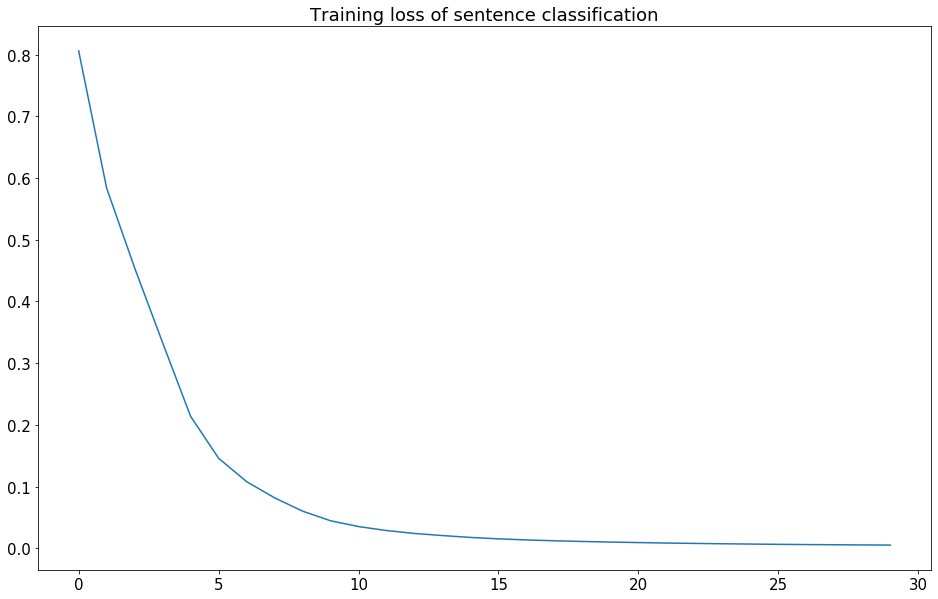

In [18]:
plt.figure()
plt.plot(tr_loss_hist)
plt.title('Training loss of sentence classification')
plt.show()

## Summary

From two previous post, we cover the many-to-one RNN model. And it is used for word/sentence classification. Especially on sentence classification, more deeper and complex model, namely stacked model, shows the good performance.

{{ 'Reference from stanford CS231n lecture note' | fndetail: 1}}
{{ 'Reference from stanford CS231n lecture note' | fndetail: 2}}
{{ 'Reference from stanford CS231n lecture note' | fndetail: 3}}